In [1]:
file_1 = "Anne_Hidalgo-2022-02-07 18_59_39.304058.csv"
file_2 = "yjadot-2022-02-07 18_18_17.385405.csv"
file_3 = "MLP_officiel-2022-02-07 19_32_28.701987.csv"
file_4 = "ZemmourEric-2022-02-07 19_34_09.012104.csv"
file_5 = "JLMelenchon-2022-02-07 19_23_51.397346.csv"
file_6 = "EmmanuelMacron-2022-02-07 19_27_54.906169.csv"
candidates =['Anne hidalgo','Yannick Jadot','Marine Le Pen','Eric Zemmour','JLMelenchon','EmmanuelMacron']

In [2]:
# !python -m spacy download fr_core_news_md

In [3]:
import pandas as pd
from keybert import KeyBERT
import re
from bertopic import BERTopic
# import nltk
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
nlp = spacy.load('fr_core_news_md')
# nltk.download('wordnet')
# nltk.download('punkt')
stopwords = list(fr_stop)
kw_model = KeyBERT()

In [4]:
df1 = pd.read_csv(file_1, encoding = 'UTF-8')
df2 = pd.read_csv(file_2, encoding = 'UTF-8')
df3 = pd.read_csv(file_3, encoding = 'UTF-8')
df4 = pd.read_csv(file_4, encoding = 'UTF-8')
df5 = pd.read_csv(file_5, encoding = 'UTF-8')
df6 = pd.read_csv(file_6, encoding = 'UTF-8')

In [5]:
df1 = df1[['tweet_text','time','time_Y_M_D']]
df2 = df2[['tweet_text','time','time_Y_M_D']]
df3 = df3[['tweet_text','time','time_Y_M_D']]
df4 = df4[['tweet_text','time','time_Y_M_D']]
df5 = df5[['tweet_text','time','time_Y_M_D']]
df6 = df6[['tweet_text','time','time_Y_M_D']]

In [8]:
df1['tweet_text']=df1['tweet_text'].apply(str)
df2['tweet_text']=df2['tweet_text'].apply(str)
df3['tweet_text']=df3['tweet_text'].apply(str)
df4['tweet_text']=df4['tweet_text'].apply(str)
df5['tweet_text']=df5['tweet_text'].apply(str)
df6['tweet_text']=df6['tweet_text'].apply(str)

In [9]:
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@' 

stopwords.extend(['avoir', 'pouvoir', 'devoir'])

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f" 
        u"\u3030"
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', text)

def preprocessing_final(tweet):
    # nlp = spacy.load('fr_core_news_md')
    # To lowercase
    punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@' 
    """function that also performs tokenization, lemmatization and removal of stopwords"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet=deEmojify(tweet)
# Creating a doc with spaCy
    doc = nlp(tweet)
    lemmas = []
    for token in doc:
        if token.pos_ != "VERB":
            lemmas.append(token.lemma_)
    return " ".join([str(x) for x in lemmas if x.isalpha() and x not in stopwords])

In [10]:
df1['preprocessed']= df1['tweet_text'].apply(preprocessing_final)
df2['preprocessed']= df2['tweet_text'].apply(preprocessing_final)
df3['preprocessed']= df3['tweet_text'].apply(preprocessing_final)
df4['preprocessed']= df4['tweet_text'].apply(preprocessing_final)
df5['preprocessed']= df5['tweet_text'].apply(preprocessing_final)
df6['preprocessed']= df6['tweet_text'].apply(preprocessing_final)

In [11]:
df = pd.concat([df1, df2, df3, df4, df5, df6], keys=[1, 2, 3, 4, 5, 6],
          names=['Series num', 'Row ID'])

In [12]:
def keyword_extraction(tweet):
    keywords=[]
    kw = kw_model.extract_keywords(tweet, keyphrase_ngram_range=(1, 1), stop_words=stopwords)
    kw.extend(kw_model.extract_keywords(tweet, keyphrase_ngram_range=(3, 3), stop_words=stopwords, 
                              use_mmr=True, diversity=0.7))
    for (k,v) in kw:
        keywords.append(k)
    
    return ' '.join(list(set(' '.join(list(set(keywords))).split())))

In [13]:
df1['keywords']= df1['preprocessed'].apply(keyword_extraction)
df2['keywords']= df2['preprocessed'].apply(keyword_extraction)
df3['keywords']= df3['preprocessed'].apply(keyword_extraction)
df4['keywords']= df4['preprocessed'].apply(keyword_extraction)
df5['keywords']= df5['preprocessed'].apply(keyword_extraction)
df6['keywords']= df6['preprocessed'].apply(keyword_extraction)

In [84]:
from pandas import Timestamp
tweet_names = []
timestamps_names = []
dict_tweets = {}
dict_timestamps = {}
dfs = {}
tweet_names_s = []
timestamps_names_s = []
dict_tweets_s = {}
dict_timestamps_s = {}
for i in [1,2,3,4,5,6]:
    df_c = eval('df'+str(i))
    df_c['year_month'] = df_c.time_Y_M_D.str[:7]
    df_c = df_c[df_c['keywords'].notna()]
    df_c = df_c[df_c['time'].notna()]
    df_c.time = pd.to_datetime(df_c['time'], dayfirst=True)
    tweet_name = "tweets"+str(i)
    timestamps_name = "timestamps"+str(i)
    tweet_names.append(tweet_name)
    timestamps_names.append(timestamps_name)
    dict_tweets[tweet_name] = df_c.keywords.to_list()
    dict_timestamps[timestamps_name] = df_c.time.to_list()
    dfs[i] = dict(tuple(df_c.groupby(df_c['year_month'])))

    for k, dff in dfs[i].items():
        dff['keywords_month']= dff['preprocessed'].apply(keyword_extraction)
        dff = dff[dff['keywords_month'].notna()]
        
        tweet_name_s = "tweets_s"+str(i)+'_'+str(k)
        tweet_names_s.append(tweet_name_s)
        dict_tweets_s[tweet_name_s] = dff.keywords.to_list()
#     for k, v in dict_tweets_s.items():
#         print(k)
# #         exec('{} = {}'.format(k,v))



for k, v in dict_tweets.items():
    exec('{} = {}'.format(k,v))

for k, v in dict_timestamps.items():
    exec('{} = {}'.format(k,v))
    
    

In [85]:
for k, v in dict_tweets_s.items():
    name = k[:-3]+'_'+str(k[-2:])
    exec('{} = {}'.format(name,v))

In [89]:
for k,v in dict_tweets_s.items():
    print(k,len(v))

tweets_s1_2021-09 421
tweets_s1_2021-10 944
tweets_s1_2021-11 611
tweets_s1_2021-12 410
tweets_s1_2022-01 473
tweets_s1_2022-02 178
tweets_s2_2021-09 740
tweets_s2_2021-10 256
tweets_s2_2021-11 323
tweets_s2_2021-12 227
tweets_s2_2022-01 394
tweets_s2_2022-02 96
tweets_s3_2021-09 151
tweets_s3_2021-10 243
tweets_s3_2021-11 297
tweets_s3_2021-12 236
tweets_s3_2022-01 386
tweets_s3_2022-02 114
tweets_s4_2021-09 154
tweets_s4_2021-10 353
tweets_s4_2021-11 327
tweets_s4_2021-12 473
tweets_s4_2022-01 879
tweets_s4_2022-02 235
tweets_s5_2021-09 45
tweets_s5_2021-10 559
tweets_s5_2021-11 863
tweets_s5_2021-12 620
tweets_s5_2022-01 957
tweets_s5_2022-02 199
tweets_s6_2021-09 107
tweets_s6_2021-10 123
tweets_s6_2021-11 100
tweets_s6_2021-12 90
tweets_s6_2022-01 81
tweets_s6_2022-02 17


In [90]:
import matplotlib.pyplot as plt
dict_topics_monthly = {}
for k,v in dict_tweets_s.items():
    name = k[:-3]+'_'+str(k[-2:])
    tweet_list = v
    topic_info = 'topic'+k[5:-3]+'_'+str(k[-2:])
    model = BERTopic(language="French")
    topics,_ = model.fit_transform(tweet_list)
    info = model.get_topic_info()
    print(topic_info, info)
    dict_topics_monthly[topic_info] = info

        


topics_s1_2021_09    Topic  Count                                          Name
0     -1     84            -1_matin_novembre_journée_hallyday
1      0     83            0_français_france_femme_exposition
2      1     77                  1_septembre_pari_soir_rendez
3      2     68                  2_vote_courage_débat_soutien
4      3     36       3_écologique_transition_climat_économie
5      4     30           4_école_enseignant_scolaire_collège
6      5     27  5_drapeau_paralympique_paralympiqu_cérémonie
7      6     16            6_hôtel_afghanistan_afghan_réfugié
topics_s1_2021_10     Topic  Count                                          Name
0      -1    261           -1_municipal_soutien_femme_candidat
1       0    147              0_france_français_parisien_ville
2       1     58         1_présidentiel_élection_vote_campagne
3       2     51                2_heure_émission_invité_demain
4       3     51         3_écologique_climatique_climat_social
5       4     39            

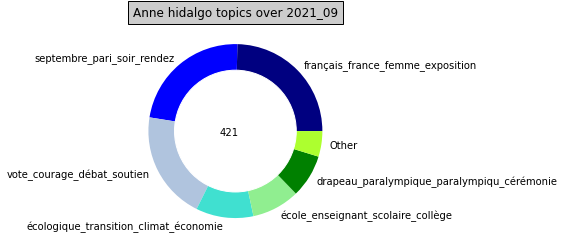

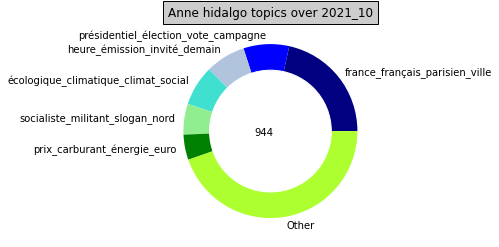

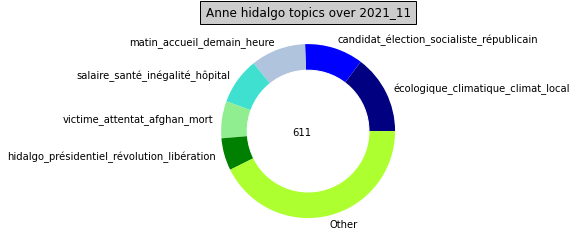

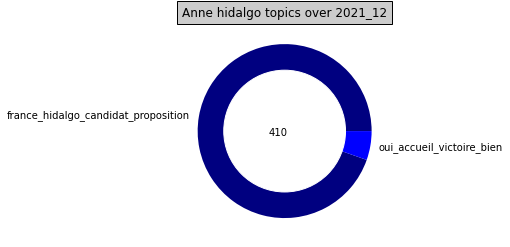

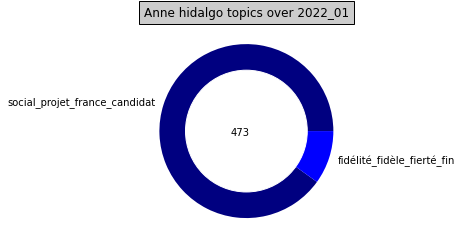

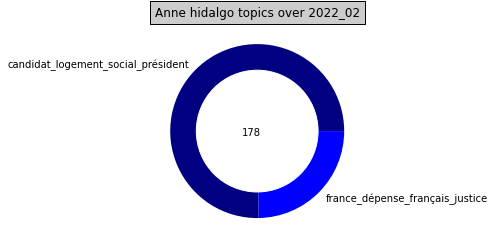

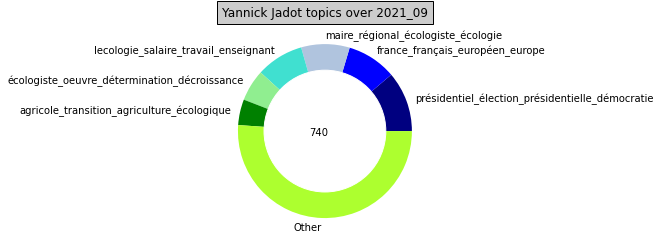

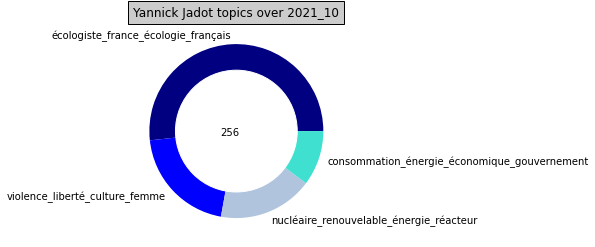

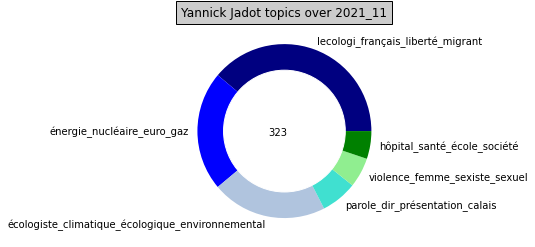

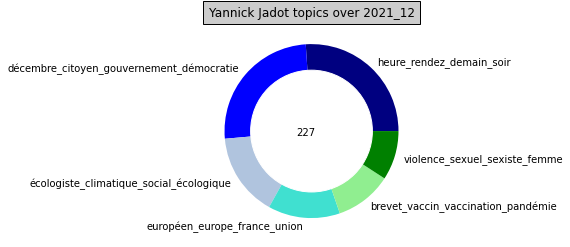

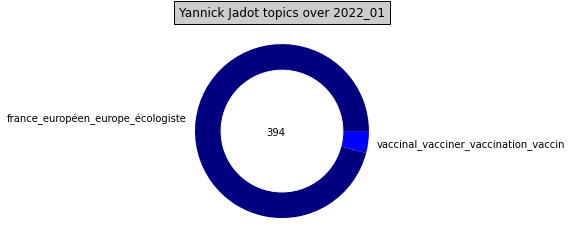

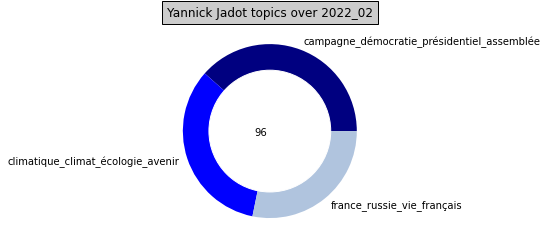

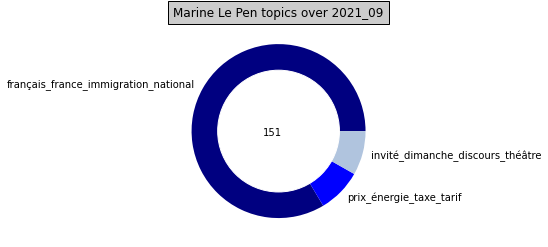

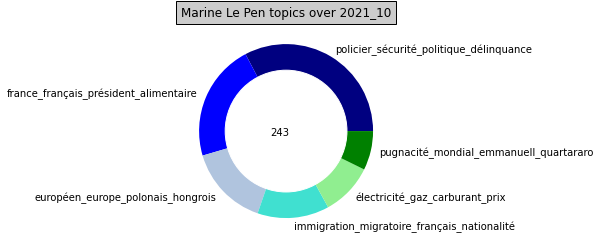

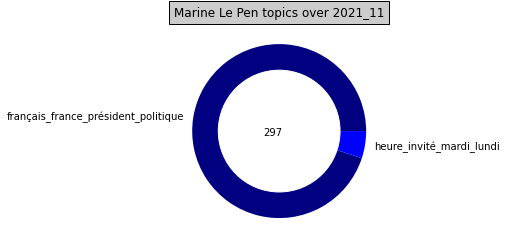

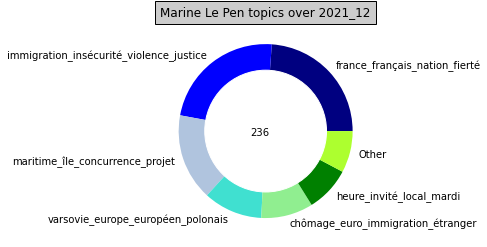

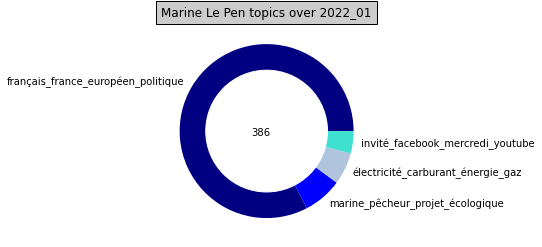

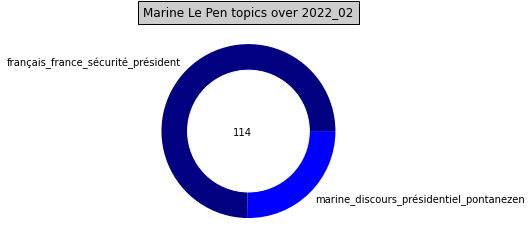

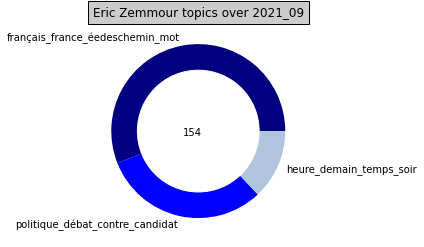

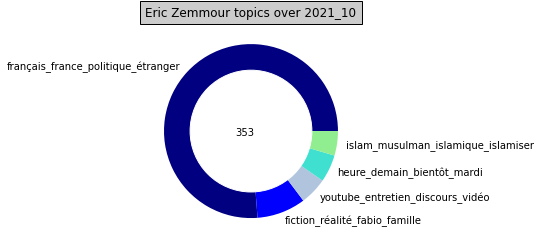

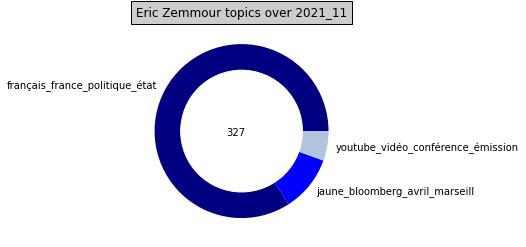

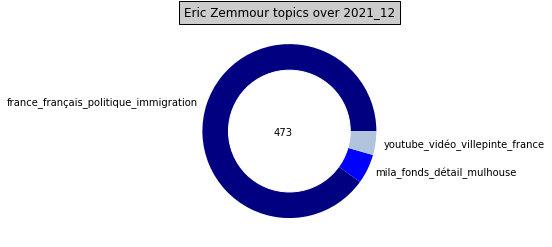

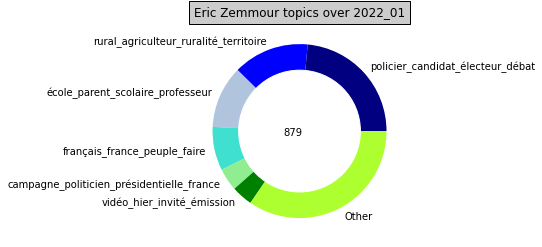

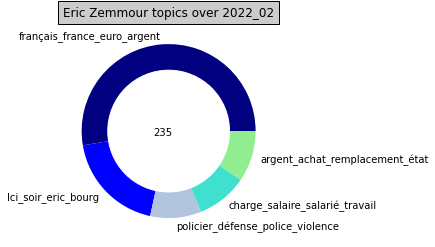

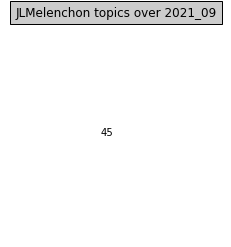

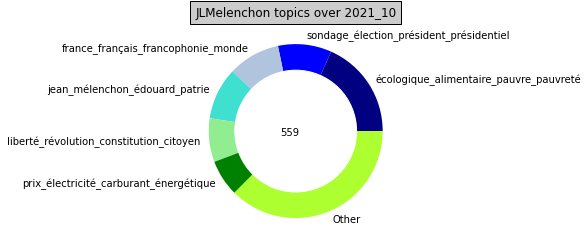

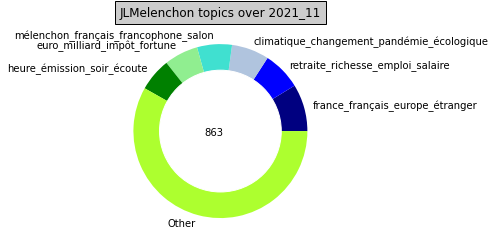

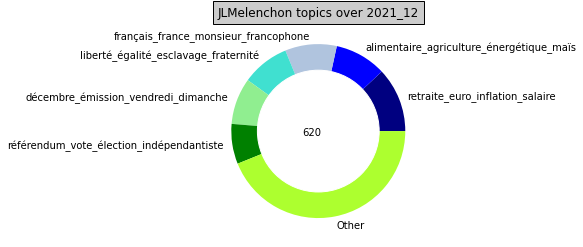

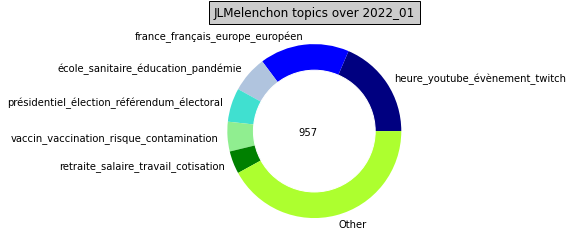

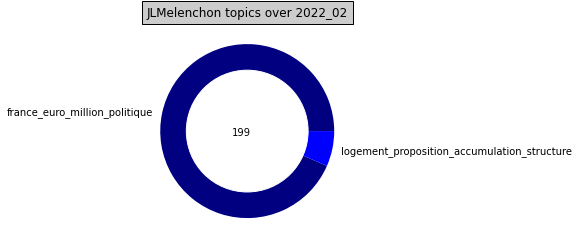

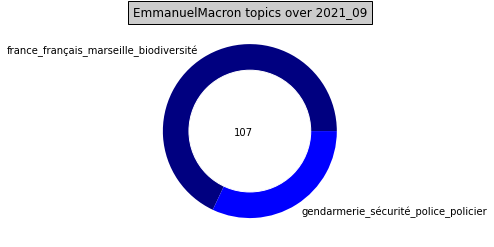

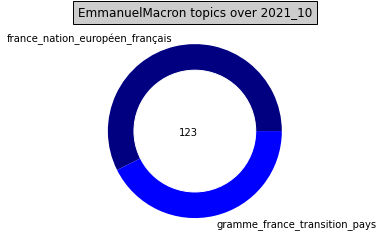

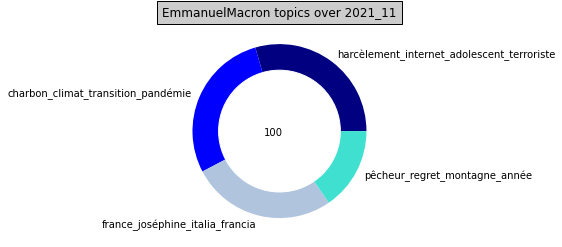

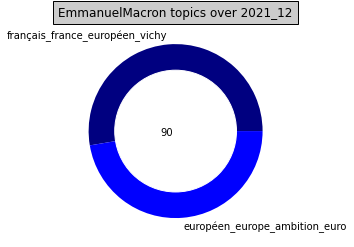

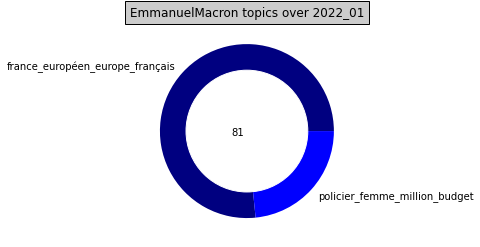

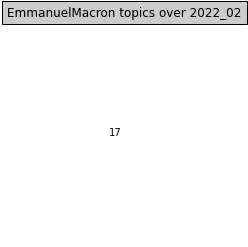

In [164]:
for k,v in dict_topics_monthly.items():
    amount = v.Count.sum()
    v = v[v["Name"].str.startswith("-1") == False]
    
    reduced = v.copy()
    reduced = reduced.replace(reduced.groupby('Name').sum().sort_values(by = ['Count'], ascending=False).index[6:],'__Other').groupby('Name').sum().copy()
    reduced = reduced.reset_index()
    names = [topic[2:] for topic in reduced.Name.to_list()]
    size = reduced.Count.to_list()


#     # Create a circle at the center of the plot
# #     fig, ((ax11, ax12, ax13, ax14, ax15, ax16), (ax21, ax22, ax23, ax24, ax25, ax26),
# #          (ax31, ax32, ax33, ax34, ax35, ax36), (ax41, ax42, ax43, ax44, ax45, ax46),
# #          (ax51, ax52, ax53, ax54, ax55, ax56), (ax61, ax62, ax63, ax64, ax65, ax66)) = plt.subplots(6, 6)
    my_circle = plt.Circle( (0,0), 0.7, color='white')
    plt.text(-.18, -.05, amount)

    # Give color names
    colors_names =['navy','blue','lightsteelblue','turquoise','lightgreen','green','greenyellow','olive']
    num = len(names)
    pallet = colors_names[:num]
    plt.pie(size, labels=names ,colors = pallet)
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title(candidates[int(k[8])-1] + " topics over " + k[10:], bbox={'facecolor':'0.8', 'pad':5})

    # Show the graph
    plot_name =candidates[int(k[8])-1]+'_'+k[10:]+'.jpg'
    plt.savefig(plot_name)
    plt.show()   


In [127]:
temp = dict_topics_monthly['topics_s5_2022_01'].copy()

In [128]:
temp.replace(temp.groupby('Name').sum().sort_values(by = ['Count'], ascending=False).index[6:],'Other').groupby('Name').sum()

,Topic,Count
Name,,
-1_droit_gouvernement_parlement_note,-1,176
0_heure_youtube_évènement_twitch,0,145
1_france_français_europe_européen,1,130
2_école_sanitaire_éducation_pandémie,2,53
3_présidentiel_élection_référendum_électoral,3,49
4_vaccin_vaccination_risque_contamination,4,43
Other,243,361


In [115]:
for k,v in dict_topics_monthly.items():
    print(k,v.Name.to_list())

topics_s1_2021_09 ['-1_matin_novembre_journée_hallyday', '0_français_france_femme_exposition', '1_septembre_pari_soir_rendez', '2_vote_courage_débat_soutien', '3_écologique_transition_climat_économie', '4_école_enseignant_scolaire_collège', '5_drapeau_paralympique_paralympiqu_cérémonie', '6_hôtel_afghanistan_afghan_réfugié']
topics_s1_2021_10 ['-1_municipal_soutien_femme_candidat', '0_france_français_parisien_ville', '1_présidentiel_élection_vote_campagne', '2_heure_émission_invité_demain', '3_écologique_climatique_climat_social', '4_socialiste_militant_slogan_nord', '5_prix_carburant_énergie_euro', '6_hôpital_santé_médecin_médical', '7_école_élève_éducation_enfant', '8_femme_citoyenneté_violence_réalité', '9_boulot_famill_faire_faur', '10_hidalgo_ann_programme_giron', '11_marché_rencontre_accueil_populaire', '12_justice_courage_dignité_mépriser', '13_droite_émocrati_vue_hauteur', '14_hidalgo_présidentiel_election_campagne', '15_maire_directrice_ministre_bürgermeisterin', '16_négationn

In [ ]:
df1 = df1[df1['keywords'].notna()]
df1 = df1[df1['time'].notna()]

df2 = df2[df2['keywords'].notna()]
df2 = df2[df2['time'].notna()]

df3 = df3[df3['keywords'].notna()]
df3 = df3[df3['time'].notna()]

df4 = df4[df4['keywords'].notna()]
df4 = df4[df4['time'].notna()]

df5 = df5[df5['keywords'].notna()]
df5 = df5[df5['time'].notna()]

df6 = df6[df6['keywords'].notna()]
df6 = df6[df6['time'].notna()]

In [ ]:
df1.time = pd.to_datetime(df1['time'], dayfirst=True)
timestamps1 = df1.time.to_list()
tweets1 = df1.keywords.to_list()

df2.time = pd.to_datetime(df2['time'], dayfirst=True)
timestamps2 = df2.time.to_list()
tweets2 = df2.keywords.to_list()

df3.time = pd.to_datetime(df3['time'], dayfirst=True)
timestamps3 = df3.time.to_list()
tweets3 = df3.keywords.to_list()

df4.time = pd.to_datetime(df4['time'], dayfirst=True)
timestamps4 = df4.time.to_list()
tweets4 = df4.keywords.to_list()

df5.time = pd.to_datetime(df5['time'], dayfirst=True)
timestamps5 = df5.time.to_list()
tweets5 = df5.keywords.to_list()

df6.time = pd.to_datetime(df6['time'], dayfirst=True)
timestamps6 = df6.time.to_list()
tweets6 = df6.keywords.to_list()

In [ ]:
topic_model1 = BERTopic(language="French")
topics1, probs1 = topic_model1.fit_transform(tweets1)


topic_model2 = BERTopic(language="French")
topics2, probs2 = topic_model2.fit_transform(tweets2)

topic_model3 = BERTopic(language="French")
topics3, probs3 = topic_model3.fit_transform(tweets3)

topic_model4 = BERTopic(language="French")
topics4, probs4 = topic_model4.fit_transform(tweets4)

topic_model5 = BERTopic(language="French")
topics5, probs5 = topic_model5.fit_transform(tweets5)

topic_model6 = BERTopic(language="French")
topics6, probs6 = topic_model6.fit_transform(tweets6)


In [ ]:
topic_model6.get_topic_info()

In [ ]:
topics_over_time1 = topic_model1.topics_over_time(tweets1, topics1, timestamps1, 
                                                global_tuning=False, 
                                                evolution_tuning=True,
                                                nr_bins=20)

topics_over_time2 = topic_model2.topics_over_time(tweets2, topics2, timestamps2, 
                                                global_tuning=False, 
                                                evolution_tuning=True,
                                                nr_bins=20)

topics_over_time3 = topic_model3.topics_over_time(tweets3, topics3, timestamps3, 
                                                global_tuning=False, 
                                                evolution_tuning=True,
                                                nr_bins=20)

topics_over_time4 = topic_model4.topics_over_time(tweets4, topics4, timestamps4, 
                                                global_tuning=False, 
                                                evolution_tuning=True,
                                                nr_bins=20)

topics_over_time5 = topic_model5.topics_over_time(tweets5, topics5, timestamps5, 
                                                global_tuning=False, 
                                                evolution_tuning=True,
                                                nr_bins=20)

topics_over_time6 = topic_model6.topics_over_time(tweets6, topics6, timestamps6, 
                                                global_tuning=False, 
                                                evolution_tuning=True,
                                                nr_bins=20)

In [ ]:
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

for i in [1,2,3,4,5,6]:
    topic_model = eval('topic_model'+str(i))
    topics = eval('topics'+str(i))
    docs = eval('tweets' + str(i))

    # Preprocess Documents
    documents = pd.DataFrame({"Document": docs,
                              "ID": range(len(docs)),
                              "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
                   for topic in range(len(set(topics))-1)]

    # Evaluate
    coherence_model = CoherenceModel(topics=topic_words, 
                                     texts=tokens, 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_v')
    coherence = coherence_model.get_coherence()
    print(candidates[i-1], '{:.3}'.format(coherence))

In [ ]:
topic_model1.visualize_topics_over_time(topics_over_time1, top_n_topics=6)
topic_model2.visualize_topics_over_time(topics_over_time1, top_n_topics=6)
topic_model3.visualize_topics_over_time(topics_over_time1, top_n_topics=6)
topic_model4.visualize_topics_over_time(topics_over_time1, top_n_topics=6)
topic_model5.visualize_topics_over_time(topics_over_time1, top_n_topics=6)
topic_model6.visualize_topics_over_time(topics_over_time1, top_n_topics=6)

In [ ]:
topics_df_1 = topics_df_1[topics_df_1["Name"].str.startswith("-1") == False]
topics_df_1 = topics_df_1[(topics_df_1['Topic'] < 10)]
topics_df_1 = topics_df_1.sort_values(by='Topic', ascending=True)

topics_df_2 = topics_df_2[topics_df_2["Name"].str.startswith("-1") == False]
topics_df_2 = topics_df_2[(topics_df_2['Topic'] < 10)]
topics_df_2 = topics_df_2.sort_values(by='Topic', ascending=True)

topics_df_3 = topics_df_3[topics_df_3["Name"].str.startswith("-1") == False]
topics_df_3 = topics_df_3[(topics_df_3['Topic'] < 10)]
topics_df_3 = topics_df_3.sort_values(by='Topic', ascending=True)

topics_df_4 = topics_df_4[topics_df_4["Name"].str.startswith("-1") == False]
topics_df_4 = topics_df_4[(topics_df_4['Topic'] < 10)]
topics_df_4 = topics_df_4.sort_values(by='Topic', ascending=True)

topics_df_5 = topics_df_5[topics_df_5["Name"].str.startswith("-1") == False]
topics_df_5 = topics_df_5[(topics_df_5['Topic'] < 10)]
topics_df_5 = topics_df_5.sort_values(by='Topic', ascending=True)

topics_df_6 = topics_df_6[topics_df_6["Name"].str.startswith("-1") == False]
topics_df_6 = topics_df_6[(topics_df_6['Topic'] < 10)]
topics_df_6 = topics_df_6.sort_values(by='Topic', ascending=True)

In [ ]:
topic_model2.visualize_topics_over_time(topics_over_time2, top_n_topics=6)

In [ ]:
topics_df_1 = topics_over_time1[['Topic','Frequency','Name','Timestamp']]
topics_df_2 = topics_over_time2[['Topic','Frequency','Name','Timestamp']]

In [ ]:
topics_df_1.to_csv(file_1[:-4]+'_topics.csv', encoding='utf-8')
topics_df_2.to_csv(file_2[:-4]+'_topics.csv', encoding='utf-8')

## Time-based Candidate Topic Relations

In [ ]:
topics_df_1['mul'] = topics_df_1['Name'] * topics_df_1['Frequency']
topics_df_2['mul'] = topics_df_2['Name'] * topics_df_2['Frequency']

In [ ]:
candid_1_topics = topics_df_1[['Name','mul','Timestamp']]
candid_2_topics = topics_df_2[['Name','mul','Timestamp']]

In [ ]:

candid_1_topics['date'] = pd.to_datetime(candid_1_topics['Timestamp']).apply(lambda x: x.date()).astype('str')
candid_2_topics['date'] = pd.to_datetime(candid_2_topics['Timestamp']).apply(lambda x: x.date()).astype('str')
candid_1_topics.index = pd.to_datetime(candid_1_topics.date)
candid_2_topics.index = pd.to_datetime(candid_2_topics.date)

In [ ]:
candid_1_topics = candid_1_topics[['mul']]
candid_2_topics = candid_2_topics[['mul']]

In [ ]:
candid_1_topics_r = candid_1_topics.resample('D').agg(lambda x: ','.join(x))
candid_2_topics_r = candid_2_topics.resample('D').agg(lambda x: ','.join(x))

In [ ]:
candid_1_topics_r['topic'] = candid_1_topics_r['mul'].apply(lambda x: ' '.join([' '.join(t.split('_')[1:]) for t in x.split(',')]))
candid_2_topics_r['topic'] = candid_2_topics_r['mul'].apply(lambda x: ' '.join([' '.join(t.split('_')[1:]) for t in x.split(',')]))

In [ ]:
similarity = {'dates':[],'sim':[]}
for ind in candid_1_topics_r.index:
    candid_1_t = candid_1_topics_r.topic[ind]
    candid_2_t = candid_2_topics_r.topic[ind]
    doc1 = nlp(candid_1_t)
    doc2 = nlp(candid_2_t)
    similarity['dates'].append(ind.date())
    similarity['sim'].append('{:.3}'.format(doc1.similarity(doc2)))
similarity_df = pd.DataFrame.from_dict(similarity,dtype=float)

In [ ]:
similarity_df

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
dates = similarity_df.dates
sim = similarity_df.sim
ax.bar(dates,sim)
plt.show()

### Overall Candidate Topic Relation

In [ ]:
topic_list_1 = [' '.join(topic.split('_')[1:]) for topic in list(set(topics_df_1.Name.to_list()))]
topic_list_2 = [' '.join(topic.split('_')[1:]) for topic in list(set(topics_df_2.Name.to_list()))]

In [ ]:
docs1 = [nlp(topic) for topic in topic_list_1]
docs2 = [nlp(topic) for topic in topic_list_2]
do_total_1 = nlp(' '.join(topic_list_1))
do_total_2 = nlp(' '.join(topic_list_2))
print(do_total_1.similarity(do_total_2))

## Pair-wise Candidate Topic Relations


In [ ]:

print(' '*17,end='')
print(*docs2 , sep = " "*5)    
for x in docs1:
    print(x.text.ljust(42), end='')
    for y in docs2:
        s = '{:.3}'.format(x.similarity(y))
        print (str(s).ljust(30), end=' ')
    print()

## similarity between topics for a single candidate

In [ ]:
!pip install fasttext

In [ ]:
import fasttext
model = fasttext.load_model("gensim-data\\cc.fr.300.bin\\cc.fr.300.bin")

In [ ]:
import numpy as np

df = pd.DataFrame({"questions":topic_list_1})

df["vecs"] = df["questions"].apply(model.get_sentence_vector)

from scipy.spatial.distance import pdist, squareform
out = pdist(np.stack(df['vecs']), metric="cosine")
cosine_similarity = squareform(out)
print(cosine_similarity)

In [ ]:
topic_model1.visualize_topics()

In [ ]:
topic_model1.visualize_heatmap()

In [ ]:
# Make Prediction
# To predict a topic of a new document, you need to add a new instance(s) on the transform method.
topics, probs = model.transform(new_docs)
topics